# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

Here's an example of the output expected. Using the small_img.zip file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](small_project.png)

# Solution

## Step 1. Segmentation. Kraken

Lets's start with the Kraken library. As the text recognition using PyTesseract takes quite some time, it might be (or might be not - finding it out is what we ought to do as researchers) a good idea to select only parts containing texts from the whole image and feed those parts to PyTesseract. First step is to import all required libraries.

In [1]:
import zipfile

import PIL
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFilter
from PIL import ImageEnhance


import pytesseract
import cv2 as cv
import numpy as np

import kraken
from kraken import pageseg
from kraken import binarization

import re

import matplotlib.pyplot as plt

Next, let's write some functions that will be of use for the further steps.
In the notebook I'll use:
- function annotations as per PEP 3107 <https://www.python.org/dev/peps/pep-3107/>
- docstring as per PEP 257 <https://www.python.org/dev/peps/pep-0257/>

In [2]:
def get_list(file_name:'str'='readonly/small_img.zip') -> 'list of str':
    '''Read and return the names of the archived images
    
    Keyword arguments:
    file_name -- the zip file containing newspaper images
    Returns:
    list of image names in the archive
    '''
    zip_names = []
    with zipfile.ZipFile(file_name, 'r') as unzipper:
        zip_names = [zfile.filename for zfile in unzipper.infolist()]
    return zip_names

def get_image(img_name:'str', zip_file:'str'='readonly/small_img.zip') -> 'PIL.Image':
    '''Extract and return the image form the zip archive
    
    Keyword arguments:
    img_name -- the filename of the required image
    zip_file -- the filename of the zip archive
    Returns:
    extracted image (in some common format)
    '''
    with zipfile.ZipFile(zip_file, 'r') as unzipper:
        return Image.open(unzipper.open(img_name))
    
def resize_image(img:'PIL.Image', ratio:'int'=1) -> 'PIL.Image':
    '''Resize and return the copy of the image
    
    Keyword arguments:
    img -- original image to resize
    ratio -- degree of compression
    Returns:
    resized image
    '''
    return img.resize((img.width//ratio, img.height//ratio))

def draw_rectanges(img:'PIL.Image', boxes:'list of tuples', color:str='red', ratio:int=1, fill=False) -> 'PIL.Image':
    '''Return a resized copy of the image with rectangles drawn in specified color
    
    Keyword arguments:
    img -- original image whose copy to use as a canvas
    boxes -- list of tuples (x1, y1, x2, y2) specifying the rectangles
    color -- rectangle frame color
    ratio -- degree of compression of the returned image
    Returns:
    resized image with rectangles in specified color
    '''
    img_rect = img.copy()
    img_canvas = ImageDraw.Draw(img_rect)
    for box in boxes:
        img_canvas.rectangle(box, outline=color, fill = fill)
        fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 10)
        fill = color
        img_canvas.text((box[0], box[1]), str(box), font=fnt, fill=fill)
    return img_rect.resize((img_rect.width//ratio, img_rect.height//ratio))

As I stated in the beginning, it might be a good idea to first segment an image into sections - specifically, those containing text and then feed those section to the text recognition library. Let's get some idea how the segmentation work by default.

In [3]:
# Use a-0.png from small_img.zip as a test image
test_img = resize_image(get_image('a-0.png'), ratio=1)
# Manually select the text areas in the image. Given coordinates (tuples) correspond with
# the image resized with the ratio 4
marked_boxes = [[150, 30, 750, 120], [35, 155, 125, 175], [370, 155, 530, 175], [775, 155, 865, 175],
               [200, 200, 700, 230], [35, 250, 860, 310], [35, 315, 860, 340], [35, 355, 175, 445],
               [35, 466, 175, 1480], [185, 910, 700, 945], [185, 960, 590, 1475], [600, 960, 870, 1475],
               [35, 1490, 105, 1525], [145, 1490, 175, 1525], [190, 1490, 500, 1525], [550, 1490, 870, 1530]]
# the marked boxes above are for 4x times scaled down image - I initially worked with smaller images,
# so now I have to resize it to fit the original size
for box in marked_boxes:
    for i in range(0, 4):
        box[i] = box[i] * 4

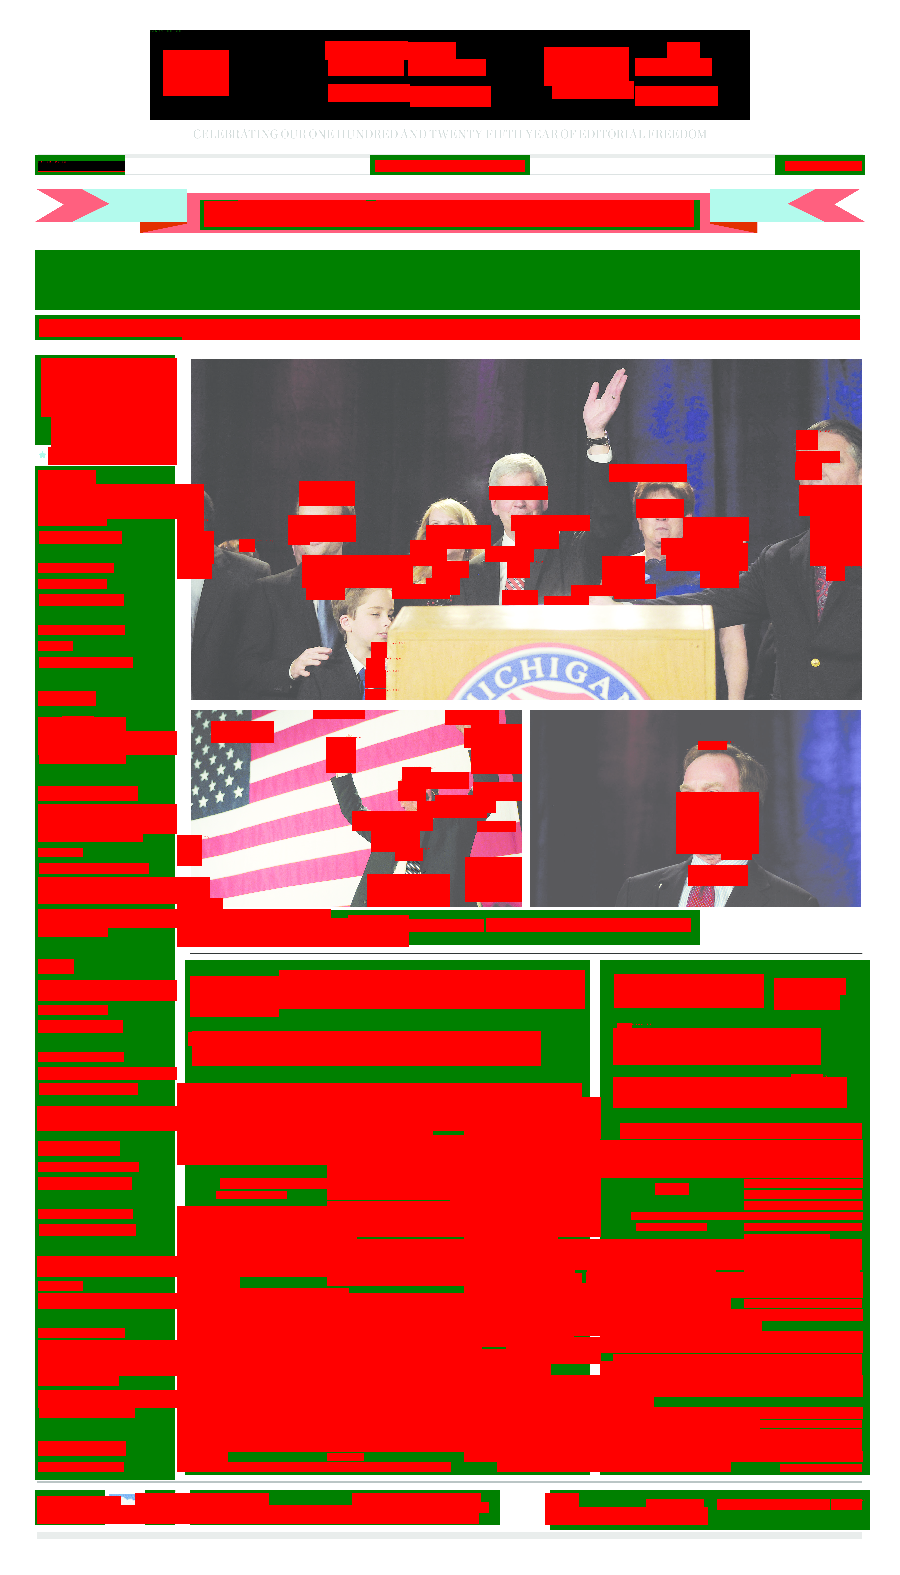

In [4]:
# Binarize the image for further segmentation
bin_test_img = binarization.nlbin(test_img)
boxes = pageseg.segment(bin_test_img)
# Draw marked areas with green and areas detected with kraken with red
img = draw_rectanges(test_img, marked_boxes, color='green')
img = draw_rectanges(img, boxes['boxes'], color='red', ratio=4)
display(img)

As we can see, the results delivered by the algorithm working with default parameters aren't at all satisfactory. So we need to take some effort to tweak the algorithm fine-tuning different parameters. Namely, those used in binarization and those used in segmentation.
Moreover, since there are going to be pretty many parameters to test, we need to come up with some metrics for automatic validation. I suggest we use the following approach: given the manually detected text boxes as in the previous cell, we measure:

- fraction of the real text areas covered by the kraken calculated segments (the more the better - ideally 100%)
- fraction of the areas which do not contain any text, at least visually recognisable, covered by the kraken calculated segments (the less the better, ideally 0%).

If we will be able to achieve ideal/close to ideal values of the proposed metrics, kraken will be a good candidate to be the first in the chain of algorithms intended to fulfill the assignment. There will be other things to take into consideration, of course, yet let's do it one step at a time.
To get the desired, we need to write some functions, facilitating the process.

Purely for better understanding - I'll use the terms box/rectangular and overlapping/intersection interchangeably (even though they may mean somewhat slightly different things)

In [5]:
def get_rect_area(rect:'coordinates') -> float:
    '''Return the area of a single box.'''
    if rect is None: return 0.
    return (rect[2] - rect[0]) * (rect[3] - rect[1])

def get_rect_total_area(rects:'coordinates') -> float:
    '''Return the arithmetic sum of areas of many boxes without taking overlapping into consideration.'''
    return sum(get_rect_area(rect) for rect in rects)
        
def get_two_rect_intersection(rect_1:'coordinates', rect_2:'coordinates') -> 'coordinates/None':
    '''Return the coordinates of the overlapping between two boxes or None if they do not overlap.'''
    target_area = (rect_1[2] - rect_1[0]) * (rect_1[3] - rect_1[1])
    # if the target rectangular is confluent, return None
    if target_area == 0:
        return None
    # is there an intersection?
    is_intersect = ((rect_1[2] > rect_2[0]) and (rect_2[2] > rect_1[0]) and (rect_1[3] > rect_2[1]) and (rect_2[3] > rect_1[1]))
    # if yes, return the intersection as a new rectangular
    if is_intersect:
        x_coord = sorted((rect_1[0], rect_1[2], rect_2[0], rect_2[2]))
        y_coord = sorted((rect_1[1], rect_1[3], rect_2[1], rect_2[3]))
        intersection_area = (x_coord[2] - x_coord[1]) * (y_coord[2] - y_coord[1])
        return (x_coord[1], y_coord[1], x_coord[2], y_coord[2])
    # if no, return None
    return None

def get_intersections(target:'list of coordinates', cover:'list of coordinates') -> 'list of coordinates':
    '''Return all overlappings between two lists of boxes without taking multiple overlappings into consideration.'''
    intersections = []
    for rect_1 in target:
        for rect_2 in cover:
            intersection = get_two_rect_intersection(rect_1, rect_2)
            if intersection is not None:
                intersections.append(get_two_rect_intersection(rect_1, rect_2))
    return intersections

def get_cross_intersection_area(rects:'list of coordinates') -> float:
    '''Return the area of overlapping between boxes in the list.'''
    intersection_area = 0.
    # if there're no or just one rectangular in the list, then there's no cross intersection
    if len(rects) <= 1: return 0.
    for i, rect_1 in enumerate(rects):
        for rect_2 in rects[i+1:]:
            intersection_area += get_rect_area(get_two_rect_intersection(rect_1, rect_2))
    return intersection_area

def get_cover_ratio(target:'list of coordinates', cover:'list of coordinates') -> float:
    '''Return the fraction to which the "cover" boxes cover the "target" boxes once.'''
    intersections = get_intersections(target, cover)
    if len(intersections) == 0: return 0.
    target_area = get_rect_total_area(target)
    total_area = sum([get_rect_area(rect) for rect in intersections])
    cross_area = get_cross_intersection_area(intersections)
    return (total_area - cross_area) / target_area

def get_false_cover_ratio(container:'coordinates', target:'list of coordinates', cover:'list of coordinates') -> float:
    '''Return the fraction to which the "cover" boxes cover the area outside of the "target" boxes once.'''
    total_cover = get_rect_total_area(cover) - get_cross_intersection_area(cover)
    true_cover = get_rect_total_area(target) * get_cover_ratio(target, cover)
    false_cover = total_cover - true_cover
    return false_cover / get_rect_area(container)

Here are the quantitative characteristics of the algorith performance:

In [6]:
img_rect = (0,0,test_img.width, test_img.height)
print('Total image size: \t\t', get_rect_area(img_rect))
print('Total image text area: \t\t', get_rect_total_area(marked_boxes))
print('Kraken cover percentage: \t', get_cover_ratio(marked_boxes, boxes['boxes']))
print('False cover percentage: \t', get_false_cover_ratio(img_rect, marked_boxes, boxes['boxes']))

Total image size: 		 22680000
Total image text area: 		 11092560
Kraken cover percentage: 	 0.620629412867724
False cover percentage: 	 0.05343346560846557


Let's start with fine-tuning binarizarion parameters by changing all of them within some ranges:

/home/user/anaconda3/lib/python3.7/site-packages/kraken/binarization.py:117: RuntimeWarning: divide by zero encountered in true_divide
  flat /= (hi-lo)


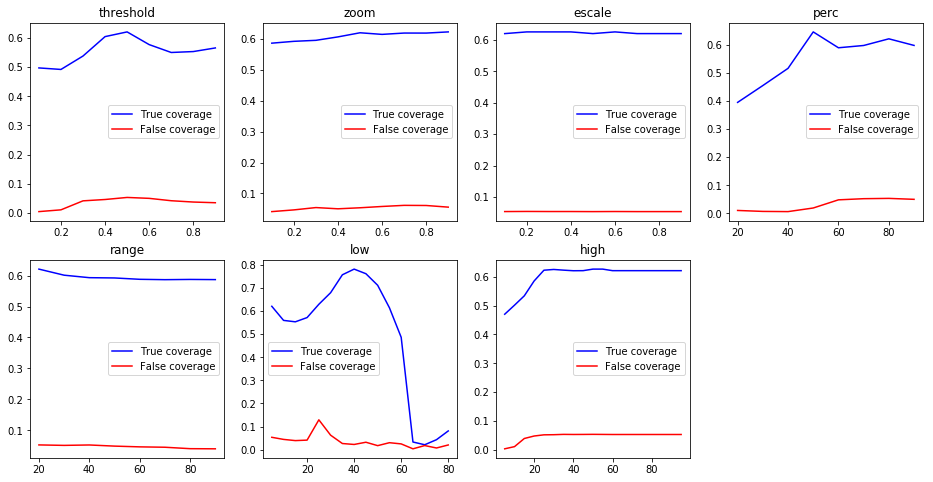

In [8]:
# Binarization parameters to test
func_params = {'threshold':np.arange(0.1, 1, 0.1),
               'zoom': np.arange(0.1, 1, 0.1),
               'escale': np.arange(0.1, 1, 0.1),
               'perc': np.arange(20, 100, 10),
               'range' : np.arange(20, 100, 10),
               'low' : np.arange(5, 85, 5),
               'high' : np.arange(5, 100, 5)}
# Iterate through all test arguments one by one leaving others at their default values
plt.figure(figsize=(16,8))
for j, param in enumerate(func_params.keys()):
    true_results, false_results = [], []
    for i in range(len(func_params[param])):
        bin_test_img = binarization.nlbin(im=test_img, **{param:func_params[param][i]})
        boxes = pageseg.segment(bin_test_img)
        true_results.append(get_cover_ratio(marked_boxes, boxes['boxes']))
        false_results.append(get_false_cover_ratio(img_rect, marked_boxes, boxes['boxes']))
    # Visualize the results
    plt.subplot(2,4,j+1)
    plt.plot(func_params[param], true_results, c='b', label='True coverage')
    plt.plot(func_params[param], false_results, c='r', label='False coverage')
    plt.legend()
    plt.title(param)
plt.show()

Now to pageseg.segment(). Out of all function's arguments we may be interested in following:

- maxcolseps (int): Maximum number of whitespace column separators
- black_colseps (bool): Whether column separators are assumed to be vertical black lines or not
- no_hlines (bool): Switch for horizontal line removal
- pad (int or tuple): Padding to add to line bounding boxes. If int the same padding is used both left and right. If a 2-tuple, uses (padding_left, padding_right).

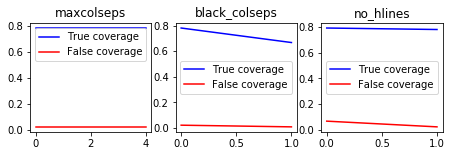

In [9]:
# Segmentation parameters to test
func_params = {'maxcolseps':np.arange(0, 5, 1),
               'black_colseps': [True, False],
               'no_hlines': [True, False]}

# Iterate through all test argument one by one leaving others at their default values
img_rect = (0,0,test_img.width, test_img.height)
bin_test_img = binarization.nlbin(im=test_img, low=40)
plt.figure(figsize=(10,2))
for j, param in enumerate(func_params.keys()):
    true_results, false_results = [], []
    for i in range(len(func_params[param])):
        boxes = pageseg.segment(im=bin_test_img, **{param:func_params[param][i]})
        true_results.append(get_cover_ratio(marked_boxes, boxes['boxes']))
        false_results.append(get_false_cover_ratio(img_rect, marked_boxes, boxes['boxes']))
    # Visualize the results
    plt.subplot(1,4,j+1)
    plt.plot(func_params[param], true_results, c='b', label='True coverage')
    plt.plot(func_params[param], false_results, c='r', label='False coverage')
    plt.legend()
    plt.title(param)
plt.show()

Analyzing the results from the two prevoius tests we see that most of the arguments, except for 'low'
in binarization have got pretty much nothing to do with improving of the quality of segmentation.
As for 'low', its optimal value is 40 with which we get the coverage ratio of 78%.
Let's see what we get in terms of the resulting sections:

Total image size: 		 22680000
Total image text area: 		 11092560
Kraken cover ratio: 	 0.7815606136004674
False cover ratio: 	 0.022439197530864197


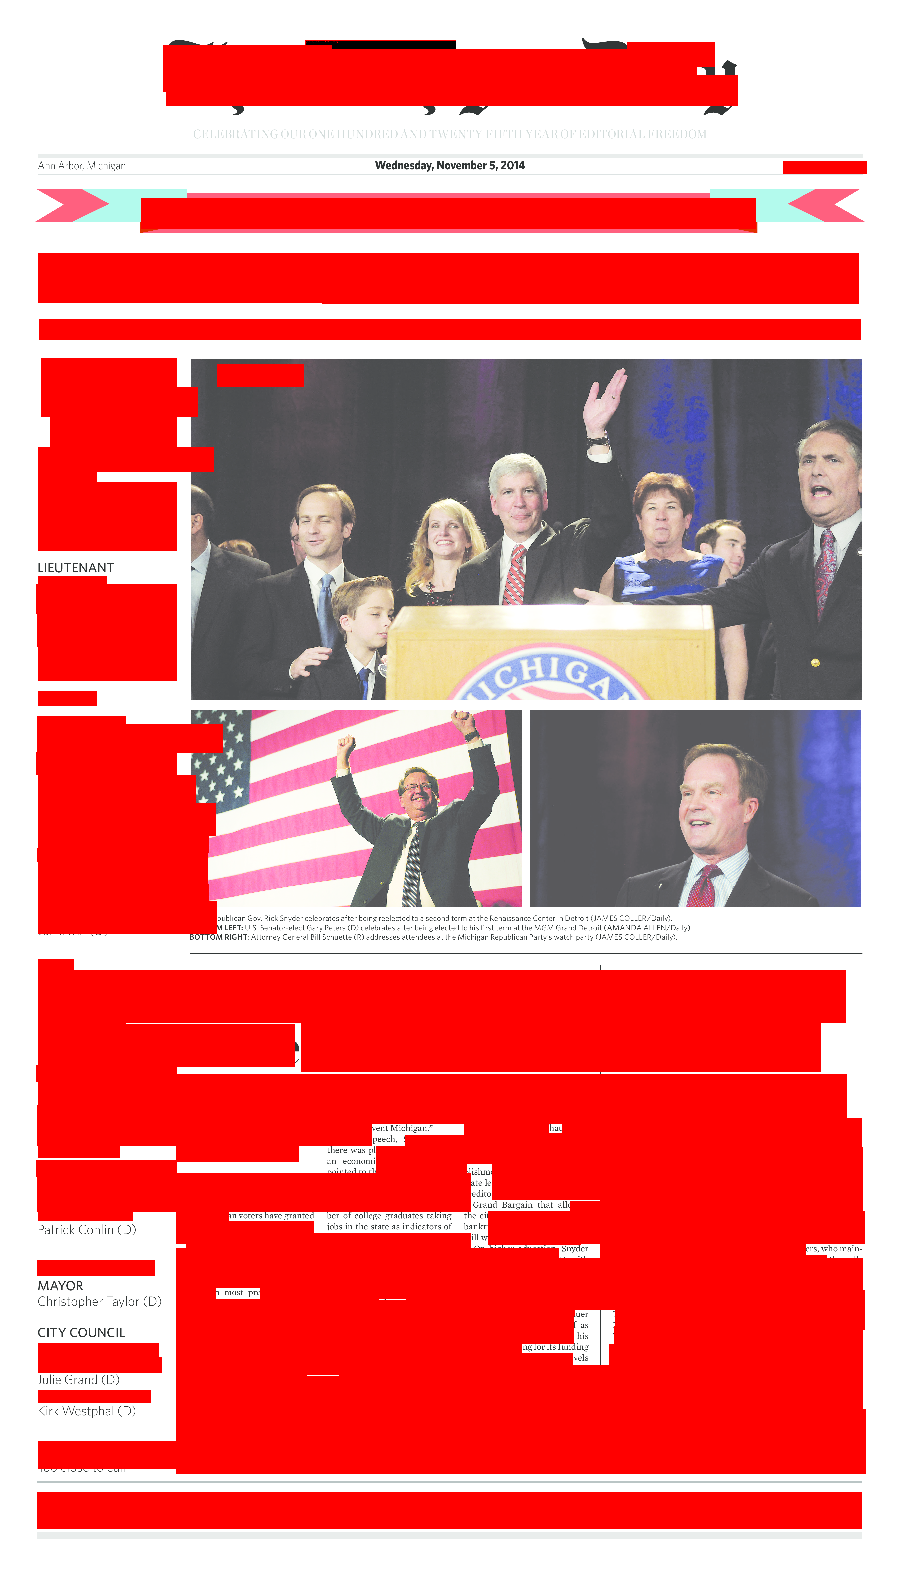

In [5]:
img_rect = (0,0,test_img.width, test_img.height)
# use optimal low=55 for binarization
bin_test_img = binarization.nlbin(im=test_img, low=40)
# all default arguments for segmentation
boxes = pageseg.segment(im=bin_test_img)
# quantitative measures
print('Total image size: \t\t', get_rect_area(img_rect))
print('Total image text area: \t\t', get_rect_total_area(marked_boxes))
print('Kraken cover ratio: \t', get_cover_ratio(marked_boxes, boxes['boxes']))
print('False cover ratio: \t', get_false_cover_ratio(img_rect, marked_boxes, boxes['boxes']))
# draw the picture with boxes
draw_rectanges(test_img, marked_boxes, color='green')
display(draw_rectanges(test_img, boxes['boxes'], color='red', ratio=4))

Sad, but true - the results aren't what we should expect. Even though most of the text area (78%) has been covered by the
boxes produced by the segmentation algorithm, there are at least two problems with this:
- the same areas have been covered by the boxes multiple times
- sometimes the boxes split text lines so that individual letters might be unrecognizable

Segmentation in this case doesn't seem to be very useful, since we initially aimed at selecting only text areas
to reduce the number of operation to be performed by the recognition algorithm.

## Step 2. PyTesseract

Now let's take a look at PyTesseract. At first we take a look at what it produces:

In [12]:
test_words = pytesseract.image_to_string(test_img).split('\n')
test_words[:10]

['Che Michigan Daily',
 '',
 'Ann Arbor, Michigan',
 '',
 'Wednesday, November 5, 2014',
 '',
 'michigandaily.com',
 '',
 'BIG DAY FOR REPUBLICANS',
 '']

We get a list of sentences which need to be in turn split into single words and each word must be validated whether it's a real English word.

In [7]:
# There'll be a number of checks if a word is in the provided dictionary - so read it once before the start
with open ("readonly/words_alpha.txt", "r") as f:
    data=f.read()
    eng_dict=data.split("\n")

def get_words(raw_words_list:'list of sentences') -> 'list of words':
    '''Split the provided list into individual English words.'''
    def validate_transform(word):
        words = []
        # transform to the lower case
        word = word.lower()
        # extract URLs - URLs stricktly speaking aren't English words, but we'll need them nethetheless 
        words.extend(re.findall('(\w+\.[a-z]{2,3})[^\w]', word))
        # extract words only consisting of small letters - we allow for possible repetitions with parts of URLs
        # (doing otherwise might also be right)
        temp_words = re.findall('[a-z]+', word)
        # check if those words are in the dictionary
        words.extend([t_word for t_word in temp_words if t_word in eng_dict])
        if len(words) > 0: return words
        
    words = []
    for word in raw_words_list:
        extracted_words = validate_transform(word)
        if extracted_words is not None:
            words.extend(extracted_words)
    # Return only unique words, list -> set -> list
    return list(set(words))

We may feed raw images or binarized images to PyTesseract - let's see what is better. Just as before, we need to come up with some metric to quantitavely measure the results.
The most obvious candidate for that is the length of the produced list.

/home/user/anaconda3/lib/python3.7/site-packages/kraken/binarization.py:117: RuntimeWarning: divide by zero encountered in true_divide
  flat /= (hi-lo)


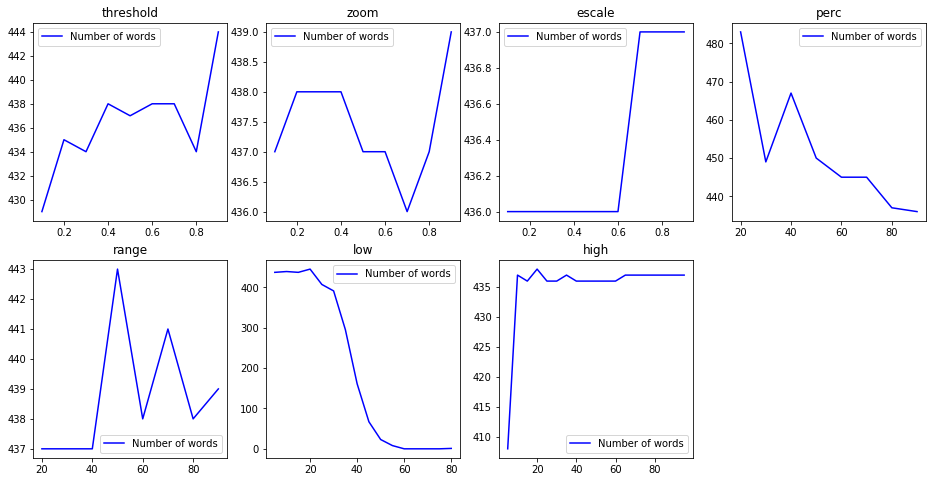

In [9]:
cached_bin_seg_results = {}
# Binarization arguments to test
# This time we will cache the results for the future tests
func_params = {'threshold':np.arange(0.1, 1, 0.1),
               'zoom': np.arange(0.1, 1, 0.1),
               'escale': np.arange(0.1, 1, 0.1),
               'perc': np.arange(20, 100, 10),
               'range' : np.arange(20, 100, 10),
               'low' : np.arange(5, 85, 5),
               'high' : np.arange(5, 100, 5)}
# Iterate through all test arguments one by one leaving others at their default values
plt.figure(figsize=(16,8))
for j, param in enumerate(func_params.keys()):
    cached_bin_seg_results[param] = {}
    test_results = []
    for i in range(len(func_params[param])):
        bin_test_img = binarization.nlbin(im=test_img, **{param:func_params[param][i]})
        result = pytesseract.image_to_string(bin_test_img).split('\n')
        cached_bin_seg_results[param][func_params[param][i]] = result
        test_results.append(len(get_words(result)))
    # Visualize the results
    plt.subplot(2,4,j+1)
    plt.plot(func_params[param], test_results, c='b', label='Number of words')
    plt.legend()
    plt.title(param)
plt.show()

By looking at the graphs we see that low has the largest variation of the number of words in the list among all parameters (0-440) and threshold (430-444), perc (440-480), high (410-435) might be somewhat meaningful. I'll omit a part of my project and detailed description of some hyperparameter tuning experiments and sum up some findings:
1. different arguments are not independent, that is, we can't just choose the best threshold and perc values and expect an even better result. To get the thorough idea about that we'll need to perform a grid search through arguments changing multiple arguments at the same time - that is too time consuming and, taking into account some other considerations, I'll leave this part for the better days 
2. Large number of words doesn't guarantee quality, that is, most of the produced words might be just meaningless garbage such as 'r, l, ss, se' etc. It might seem reasonable to just filter out short words, but I'd rather not do that - surely, out of real short words articles and prepositions etc. aren't really needed - they can be found in almost every English text - and yet we may lose, should we employ this approach, any mention of, say, 'R and C programming languages' and some others.

Luckily, here is one thing we can do to validate the results. From the assignment we know that a-1.png contains the word 'Christopher'. Not that it is a very rare and old word only used in the days of William Shakespeare, but rare enough not to expect its appearance in every article. Let's see when we don't detect it:

In [10]:
for param in cached_bin_seg_results.keys():
    for value in cached_bin_seg_results[param]:
        if ('christopher' in get_words(cached_bin_seg_results[param][value])) == False:
            print(param, '\t', value, '\t', False)

perc 	 20 	 False
low 	 25 	 False
low 	 30 	 False
low 	 35 	 False
low 	 40 	 False
low 	 45 	 False
low 	 50 	 False
low 	 55 	 False
low 	 60 	 False
low 	 65 	 False
low 	 70 	 False
low 	 75 	 False
low 	 80 	 False


Just as expected for low and a bit counterintuitive for perc.
So, looks like default binarization parameters works just well and there's no need to tune them up. One last thing I'd like to do is check whether the algorithm catches all the text areas in the article or not.

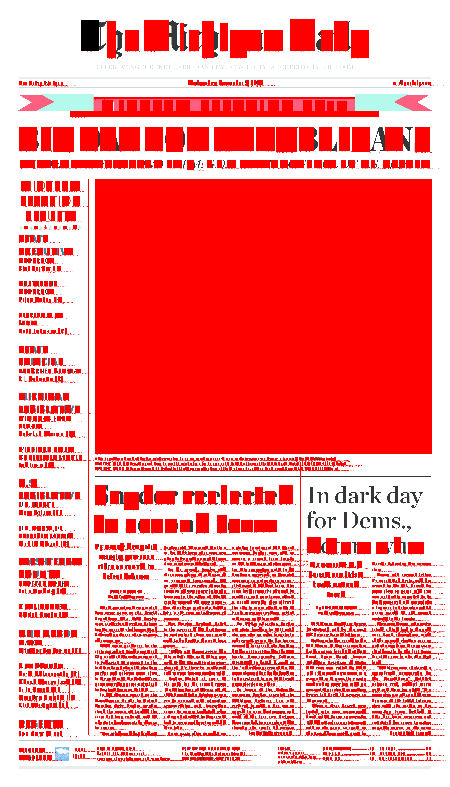

In [161]:
bin_test_img = binarization.nlbin(im=test_img)
result = pytesseract.image_to_boxes(bin_test_img, output_type='dict')

OCR_boxes = []
for i in range(len(result['left'])):
    OCR_boxes.append([result['left'][i], test_img.height - result['bottom'][i], result['right'][i], test_img.height - result['top'][i]])
draw_rectanges(test_img, OCR_boxes, fill=True,ratio=8)

Not bad, give or take. Looks like there's no much we can do to make it better.

## Step 3. OpenCV

Some useful functions to start with.

In [11]:
def CVtoPIL_boxes(boxes:'list of CV boxes') -> 'list of PIL boxes':
    '''Return PIL boxes (x1,y1,x2,y2) from CV boxes (x,y,w,h)'''
    PIL_boxes = []
    for box in boxes:
        PIL_boxes.append([box[0], box[1], box[0]+box[2], box[1]+box[3]])
    return PIL_boxes

def get_face_detection_ratios(coordinates:'list of (x,y)', boxes:'list of PIL boxes')->'dict':
    '''Return the dictionary containing tp, fp, fn, precision, recall and f1 metrics of how boxes cover coordinates'''
    # True Positive, False Positive, False Negative 
    tp, fp, fn = 0, 0, 0
    total_boxes, total_faces = len(boxes), len(coordinates)
    for coordinate in coordinates:
        for box in boxes:
            # x and y of the face coordinates must be strictly within a box
            if coordinate[0] in range(box[0]+1, box[2]) and coordinate[1] in range(box[1]+1, box[3]):
                tp += 1
                # there may be a situation when one face is covered by several boxes -
                # - so we need to stop iterating through boxes once a box overlapping
                # the face has been found in order not to derive the biased True Positives
                break
    fp = total_boxes - tp 
    fn = total_faces - tp
    precision, recall, f1 = None, None, None
    if (tp+fp)!=0: precision = tp/(tp+fp)
    if (tp+fn)!=0: recall = fp/(tp+fn)
    if (precision is not None) and (recall is not None): f1 = 2*precision*recall/(precision+recall)
    return {'tp':tp, 'fp':fp, 'fn':fn, 'precision':precision, 'recall':recall, 'f1':f1 }

def coordinates_to_boxes(coordinates:'list of (x, y)', span:int=20) -> 'list of PIL boxes':
    boxes = []
    for coordinate in coordinates:
        boxes.append([coordinate[0] - span, coordinate[1] - span, coordinate[0] + span, coordinate[1] + span])
    return boxes

First, take a look at how face detection works on our test image

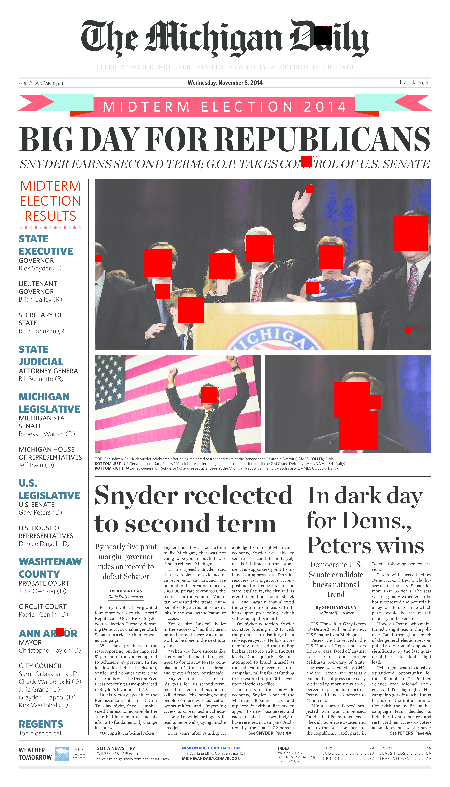

In [12]:
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
eyes_cascade = cv.CascadeClassifier('readonly/haarcascade_eye.xml')

marked_faces = [[820, 468], [519, 498], [661, 514], [316, 526], [446 ,532], [702 ,800], [723 ,551], [364, 606], [416 ,795]]
for box in marked_faces:
    for i in range(0, 2):
        box[i] = box[i] * 4

CV_test_img = np.array(test_img)
CV_test_img = cv.cvtColor(CV_test_img, cv.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(CV_test_img)
draw_rectanges(test_img, CVtoPIL_boxes(faces), color='red', ratio=8)

We can see that the algorithm successfully detected some of the faces, missed some and made some false predictions. We will measure the performance of the algorithm using the following metrics: True Positive, False Positive, False Negative. For the sake of the moment I must add that I also tried using precision, recall and the integral f1 for the same purpose, but the conclusion made with, say, f1 is somewhat counter-intuitive and doesn't make much sense for the purpose of this assignment (in my humble opinion, of course).

Using the same approaches as previously, test OpenCV performance with different arguments.

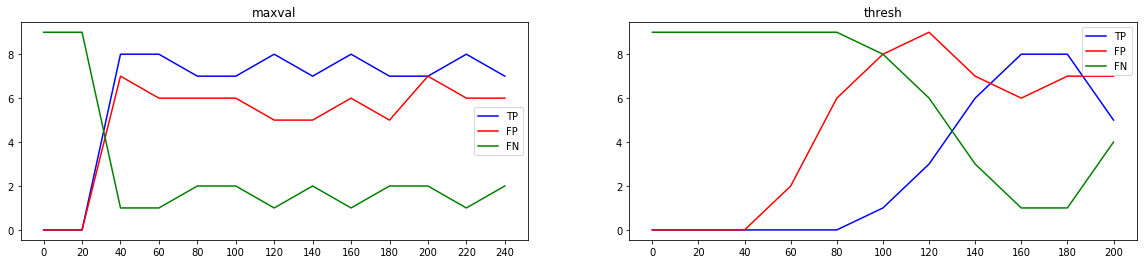

In [9]:
plt.figure(figsize=(20,4))

# Binarization arguments to test
func_params = {'maxval': np.arange(0, 260, 20)}
for param in func_params.keys():
    tp_results, fp_results, fn_results = [], [], []
    for i in range(len(func_params[param])):
        bin_test_img = cv.threshold(src=CV_test_img, thresh=160, type=cv.THRESH_BINARY, **{param:func_params[param][i]})[1]
        faces = face_cascade.detectMultiScale(image=bin_test_img)
        results = get_face_detection_ratios(marked_faces, CVtoPIL_boxes(faces))
        tp_results.append(results['tp'])
        fn_results.append(results['fn'])
        fp_results.append(results['fp'])
    plt.subplot(1,2,1)
    plt.plot(func_params[param], tp_results, c='b', label='TP')
    plt.plot(func_params[param], fp_results, c='r', label='FP')
    plt.plot(func_params[param], fn_results, c='g', label='FN')
    plt.title(param)
    plt.xticks(func_params[param])
    plt.legend()

func_params = {'thresh': np.arange(0, 220, 20)}
for param in func_params.keys():
    tp_results, fp_results, fn_results = [], [], []
    for i in range(len(func_params[param])):
        bin_test_img = cv.threshold(src=CV_test_img, maxval=60, type=cv.THRESH_BINARY, **{param:func_params[param][i]})[1]
        faces = face_cascade.detectMultiScale(image=bin_test_img)
        results = get_face_detection_ratios(marked_faces, CVtoPIL_boxes(faces))
        tp_results.append(results['tp'])
        fn_results.append(results['fn'])
        fp_results.append(results['fp'])
    plt.subplot(1,2,2)
    plt.plot(func_params[param], tp_results, c='b', label='TP')
    plt.plot(func_params[param], fp_results, c='r', label='FP')
    plt.plot(func_params[param], fn_results, c='g', label='FN')
    plt.title(param)
    plt.xticks(func_params[param])

    plt.legend()
plt.show()

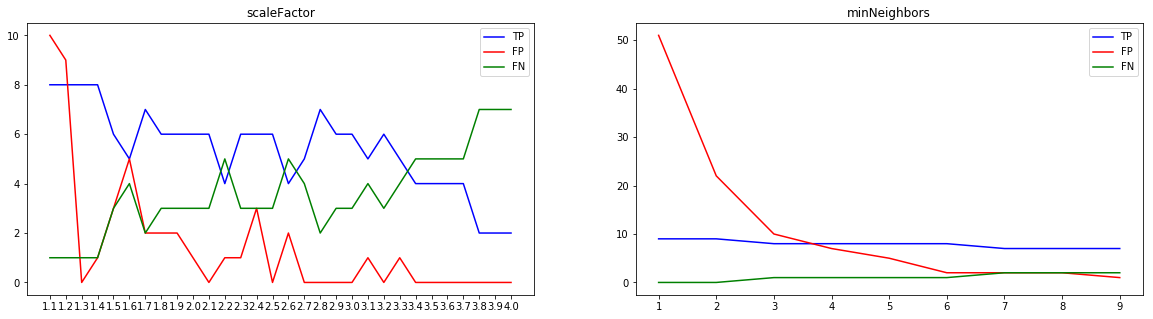

In [10]:
plt.figure(figsize=(20,5))

# bin_test_img = cv.threshold(src=CV_test_img, thresh=140, type=cv.THRESH_BINARY, maxval=120)[1]
# Detection arguments to test
func_params = {'scaleFactor': np.arange(1.1, 4.1, 0.1),
               'minNeighbors': np.arange(1, 10, 1)}
for j, param in enumerate(func_params.keys()):
    tp_results, fp_results, fn_results = [], [], []
    for i in range(len(func_params[param])):
        faces = face_cascade.detectMultiScale(image=CV_test_img, **{param:func_params[param][i]})
        results = get_face_detection_ratios(marked_faces, CVtoPIL_boxes(faces))
        tp_results.append(results['tp'])
        fn_results.append(results['fn'])
        fp_results.append(results['fp'])
    plt.subplot(1,2,j+1)
    plt.plot(func_params[param], tp_results, c='b', label='TP')
    plt.plot(func_params[param], fp_results, c='r', label='FP')
    plt.plot(func_params[param], fn_results, c='g', label='FN')
    plt.title(param)
    plt.xticks(func_params[param])
    plt.legend()

plt.show()

The algorithm seems to be producing the best results (surely, 'the best' is somewhat subjective and gets only visually defined, the general principle, though, is that we're interested in maximizing True Positives and minimizing both False Negative and False Positive) with binarization arguments: thresh=180 and maxval=80 / detection arguments: scaleFactor=1.1 and minNeighbors=6. One observation that we can make from the graphs is that no argument value gives us zero False Negative, that is, mostly likely we can't detect all the faces in a picture.

And one more thing before we go further: on the previous pictures we've seen that the classifier tends to (falsely) identify some small areas as faces. We can fix this by defining minSize. Logically it's pretty reasonable - after all, newspapers are supposed to be read by humans and if a man can't see a face simply because it's too small, the algorithm shouldn't detect the face as well. With that in mind, I'll make minSize=(150, 150)

Lets's see what the result looks on the real picture:

{'tp': 8, 'fp': 0, 'fn': 1, 'precision': 1.0, 'recall': 0.0, 'f1': 0.0}


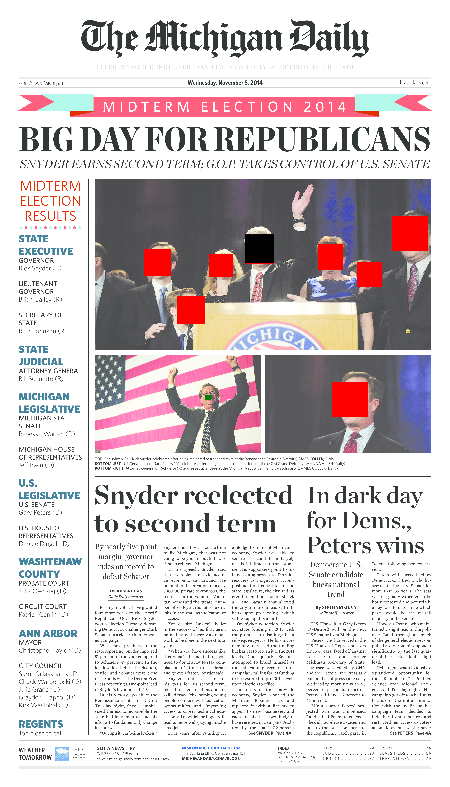

In [31]:
img_4 = resize_image(test_img, ratio=1)
CV_test_img = np.array(img_4)

bin_test_img = cv.threshold(src=CV_test_img, thresh=180, type=cv.THRESH_BINARY, maxval=80)[1]
faces = face_cascade.detectMultiScale(bin_test_img,  scaleFactor=1.1, minNeighbors=6, minSize=(150, 150))
print(get_face_detection_ratios(marked_faces, CVtoPIL_boxes(faces)))
img = draw_rectanges(img_4, coordinates_to_boxes(marked_faces), color='green')
draw_rectanges(img, CVtoPIL_boxes(faces), color='red', ratio = 8)

## Final Step. Putting it all together.

I'll sum up what we've got from the previous steps so far:
1. Kraken won't be used for segmenting a raw image into sections containing texts, except for binarization function
2. Images will be fed to PyTesseract for processing after binarazing them with threshold=0.7
3. For face detection with OpenCV images will be binarized with thresh=180 and maxval=80 and then passed to the classifier with scaleFactor=1.1 and minNeighbors=6

Let's start.

In [35]:
# Read the names of the files from the archive
zip_archive = 'readonly/small_img.zip'
file_list = get_list(zip_archive)
# The dataset for processing requests will be stored as a dictionary
data_dict = dict()
# Process each image one by one extracting words and faces
for img_name in file_list:
    # extract image, binarize, get words, binarize, get faces
    current_words, current_faces = [], []
    current_image = resize_image(get_image(img_name, zip_archive), ratio=1)
    binarized_image = binarization.nlbin(im=current_image, threshold=0.7)
    current_words = get_words(pytesseract.image_to_string(bin_test_img).split('\n'))
    CV_current_image = np.array(current_image)
    binarized_image = cv.threshold(src=CV_current_image, thresh=180, type=cv.THRESH_BINARY, maxval=80)[1]
    current_faces = face_cascade.detectMultiScale(binarized_image,  scaleFactor=1.1, minNeighbors=6, minSize=(150, 150))
    data_dict[img_name] = dict()
    data_dict[img_name]['file_name'] = img_name
    data_dict[img_name]['raw_image'] = current_image
    data_dict[img_name]['words'] = current_words
    data_dict[img_name]['faces'] = CVtoPIL_boxes(current_faces)

In [36]:
def word_search(word:'str') -> 'PIL.Image':
    '''Look for entries in data_dict containing the passed argument and return the image as per task.'''
    
    def get_item_image(item:'str/file_name') -> 'PIL.Image':
        '''Get the visual representation for a single item in data_dict.'''
        no_faces_str = 'The word has been found in {}, but there are no faces'
        found_str = 'The word has been found in {}'
        if len(data_dict[item]['faces']) == 0:
            sub_contact_sheet = PIL.Image.new(mode='RGB', size=(cs_w, caption_h), color='white')
            ImageDraw.Draw(sub_contact_sheet).text((0, 0), no_faces_str.format(item), fill='black', font=fnt)
            return sub_contact_sheet
        else:
            # the resulting image (sub_contact_sheet) will be combined of caption_sheet and faces_sheet 
            # heights of face_sheet and contact
            num_faces = len(data_dict[item]['faces'])
            fs_h = (((num_faces - 1) // num_faces)+1) * face_h
            cs_h = caption_h + fs_h
            # create sub_contact_shee, caption_sheet and faces_sheet 
            caption_sheet = PIL.Image.new(mode='RGB', size=(cs_w, caption_h), color='white')
            faces_sheet = PIL.Image.new(mode='RGB', size=(cs_w, fs_h), color='white')
            sub_contact_sheet = PIL.Image.new(mode='RGB', size=(cs_w, cs_h), color='white')
            # fill in caption_sheet
            ImageDraw.Draw(caption_sheet).text((0, 0), found_str.format(item), fill='black', font=fnt)
            # fill in faces_sheet
            for i, face in enumerate(data_dict[item]['faces']):
                face_img = data_dict[item]['raw_image'].crop(face).resize((face_w, face_h))
                coords = ( i%8*face_w, i//8*face_h, (i%8+1)*face_w, (i//8)+1*face_h )
                faces_sheet.paste(face_img, coords)
        # populate and return sub_contact_sheet
        sub_contact_sheet.paste(im=caption_sheet, box=(0, 0, cs_w, caption_h))
        sub_contact_sheet.paste(im=faces_sheet, box=(0, caption_h, cs_w, caption_h + faces_sheet.height))        
#         print(item, sub_contact_sheet.height, sub_contact_sheet.width)
        return sub_contact_sheet
    
    word = word.lower()
    cs_w, caption_h, face_w, face_h = 800, 20, 100, 100
    fnt = ImageFont.truetype('FreeMono.ttf', size=20)
    results = []
    images = []
    no_results_str = 'No results have been found'
    for item in data_dict:
        if word in data_dict[item]['words']:
            results.append(data_dict[item]['file_name'])
    num_results = len(results)
    if num_results == 0:
        contact_sheet = PIL.Image.new(mode='RGB', size=(cs_w, caption_h), color='white')
        ImageDraw.Draw(contact_sheet).text((0, 0), no_results_str, fill='black', font=fnt)
        return contact_sheet
    for item in results:
        image = get_item_image(item)
        images.append(image)
    total_h = sum([image.height for image in images])
    contact_sheet = PIL.Image.new(mode='RGB', size=(cs_w, total_h), color='white')
    pos_y = 0
    for image in images:
        contact_sheet.paste(im=image, box=(0, pos_y, cs_w, pos_y+image.height))
        pos_y += image.height
    return contact_sheet

Finally. Test. Christopher and Mark.

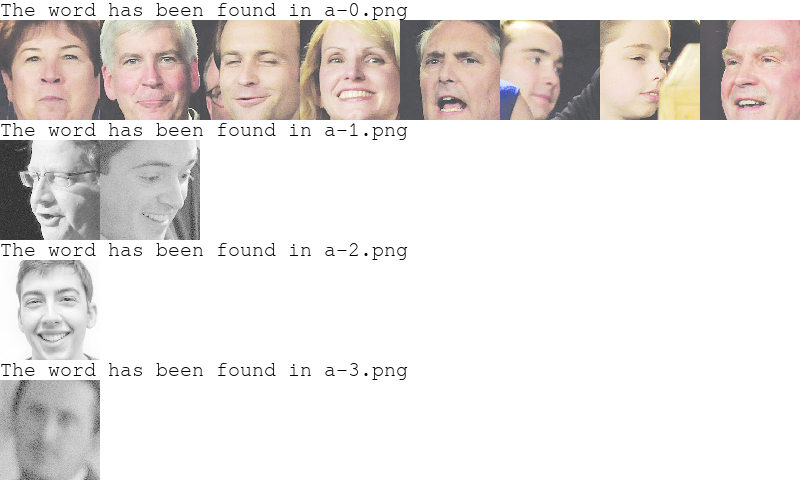

In [37]:
word_search('Christopher')

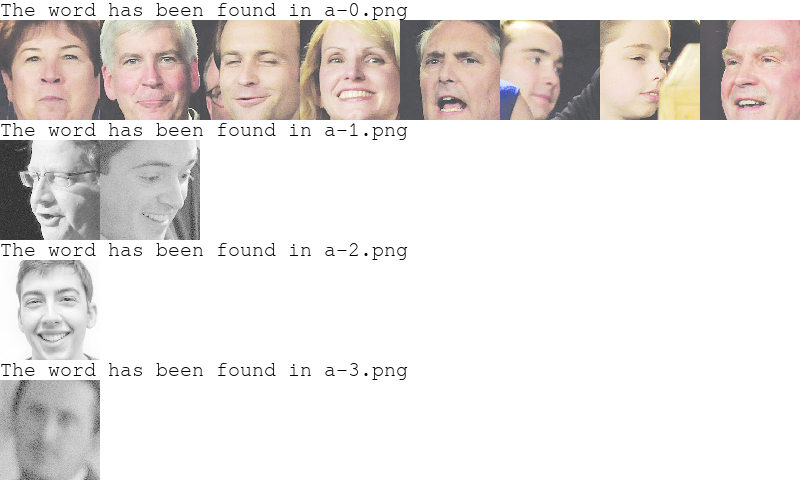

In [38]:
word_search('Mark')